In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
from dpeva.uncertain.rnd import RandomNetworkDistillation

Initializing DP-EVA version 0.1.0


## Load descriptor example, 

descriptor shape : (nframe, ndim)

In [3]:
desc = np.load('../data/desc.npy')
desc.shape

(20873, 136)

## Random Network Distillation

The Random Network Distillation (RND) is a method to learn the representation of the environment and calculate the intrinsic reward of the target data. The idea is to train a neural network to predict the output of a fixed randomly initialized neural network. The fixed network is used to generate the target, and the trainable network is used to predict the target. The intrinsic reward is calculated by the difference between the target and the prediction which is used to train the agent to explore the environment. 

Here in MLIP active learning ,the 'agnet' is our MLIP and the environment is the atomistic space.

In [4]:
%%time
# parameters, can be tuned
input_dim = desc.shape[-1]  # input dimension
output_dim = desc.shape[-1]   # output dimension, no need to be the same as input_dim. here we use the same dimension for simplicity
hidden_dim = 240  # hidden dimension
num_residual_blocks = 1  # number of residual blocks

# initialization
rnd = RandomNetworkDistillation(
            input_dim=input_dim, 
            output_dim=input_dim, 
            hidden_dim=hidden_dim, 
            num_residual_blocks=num_residual_blocks, 
            distance_metric="cossim", 
            use_normalization=False)

# fit the predictor network
rnd.train(desc, 
          num_epochs=40, 
          batch_size=4096, 
          initial_lr=1e-3, 
          gamma=0.90, 
          loss_down_step=5,)

# save the target and predictor networks
# rnd.save_predictor_network("rnd_predictor.pth")
# rnd.save_target_network("rnd_target.pth")

2025-01-10 18:14:41,211 - dpeva.uncertain.rnd - INFO - Epoch 1/40 started, learning rate: 0.001000
2025-01-10 18:14:41,460 - dpeva.uncertain.rnd - INFO - Epoch 1/40 completed, Time: 0.25s, Loss: 0.552381
2025-01-10 18:14:41,461 - dpeva.uncertain.rnd - INFO - Epoch 2/40 started, learning rate: 0.000900
2025-01-10 18:14:41,642 - dpeva.uncertain.rnd - INFO - Epoch 2/40 completed, Time: 0.18s, Loss: 0.092776
2025-01-10 18:14:41,643 - dpeva.uncertain.rnd - INFO - Epoch 3/40 started, learning rate: 0.000900
2025-01-10 18:14:41,819 - dpeva.uncertain.rnd - INFO - Epoch 3/40 completed, Time: 0.18s, Loss: 0.060569
2025-01-10 18:14:41,820 - dpeva.uncertain.rnd - INFO - Epoch 4/40 started, learning rate: 0.000900
2025-01-10 18:14:41,992 - dpeva.uncertain.rnd - INFO - Epoch 4/40 completed, Time: 0.17s, Loss: 0.045961
2025-01-10 18:14:41,992 - dpeva.uncertain.rnd - INFO - Epoch 5/40 started, learning rate: 0.000900
2025-01-10 18:14:42,179 - dpeva.uncertain.rnd - INFO - Epoch 5/40 completed, Time: 0.

CPU times: user 1min 39s, sys: 7.48 s, total: 1min 46s
Wall time: 8.01 s


After training for predictor network, we can use the distance between target network and predictor network as the intrinsic reward for data to be sampled

In [5]:
%%time
intrinsic_rewards = []
batch_size = 4096 

# transform intrinsic_rewards to numpy array
intrinsic_rewards = rnd.eval_intrinsic_rewards(desc, batch_size=batch_size)

2025-01-10 18:14:48,558 - dpeva.uncertain.rnd - INFO - Calculating intrinsic rewards for target vector of size 20873 with batch size 4096
2025-01-10 18:14:48,559 - dpeva.uncertain.rnd - INFO - Calculating intrinsic rewards for batch 1/5
2025-01-10 18:14:49,959 - dpeva.uncertain.rnd - INFO - Calculating intrinsic rewards for batch 2/5
2025-01-10 18:14:51,441 - dpeva.uncertain.rnd - INFO - Calculating intrinsic rewards for batch 3/5
2025-01-10 18:14:52,853 - dpeva.uncertain.rnd - INFO - Calculating intrinsic rewards for batch 4/5
2025-01-10 18:14:54,337 - dpeva.uncertain.rnd - INFO - Calculating intrinsic rewards for batch 5/5
2025-01-10 18:14:55,713 - dpeva.uncertain.rnd - INFO - Calculating intrinsic rewards for batch 6/5
2025-01-10 18:14:55,852 - dpeva.uncertain.rnd - INFO - Intrinsic rewards calculation done


Indices of Top 200 points with highest intrinsic rewards: [ 2487 14297  3177  2581 16437 10360  4406 13032 19054  8427  2086 20208
  2831 14362  6260 14395  8823 17758 11970 15099 19583 18426   862  6661
 11597  7992 11417  2496 11412 14081  9835  8233 14263 18019  6248 11262
 17755 19879  4417  9318  2475 12798 17940  3773 12284 16861 15611 11194
 19746 13298 14927  1671  1787  5165 10287  8797  2488 18152 20427   144
 13867  6243  7672 17403 14638 15545 10285  9611  4673 15851  2188  7663
 12325 12755   894  6802   364   324 20324  2759 10384  1706 19684 11287
 16659  8862 18201  1438  8143 16473  6177  6780 10645  2286  8997 20240
  2852  4591  7164  7514 14141 16342  7601  7935 12372  4640 12280 19730
  4084 19168 10003 13766  1351  6855 17695 15976  2625 17063  5603 19876
 19145 19137  9131 12793 14958 13627 16628 12724 16703 17781  7802 15631
 14543 10949 14162  5779   747 20133  3389  2068  9991 17739  7414 18798
  5021  5394 17679 19092 13374  8477 20375 17752 19816  3375 18671

In [ ]:
# top 200 unique points
top_50_indices = np.argsort(intrinsic_rewards)[-50:]  
top_50_points = desc[top_50_indices]  

print("Indices of Top 200 points with highest intrinsic rewards:", top_50_indices)

## Visualizing the uncertainty (reward) results

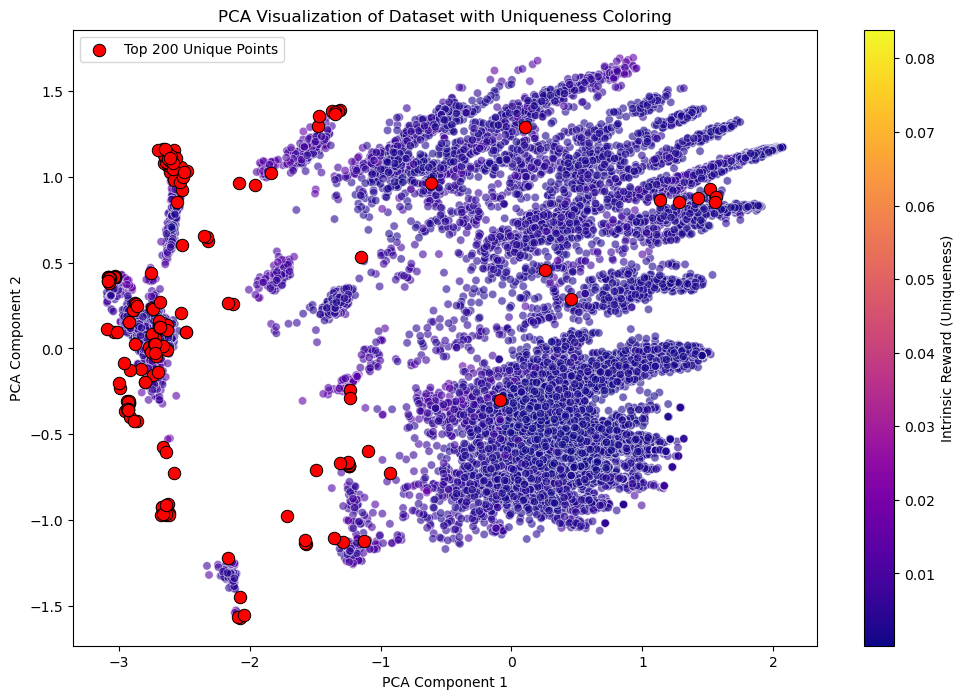

In [6]:
# PCA reduction
pca = PCA(n_components=2) 
pca_result = pca.fit_transform(desc) 
top_50_pca_result = pca.transform(top_50_points) # PCA reduction for top 200 unique points in the same space

plt.figure(figsize=(12, 8))

ax = sns.scatterplot(
    x=pca_result[:, 0], y=pca_result[:, 1],
    hue=intrinsic_rewards, palette="plasma", alpha=0.6, legend=False
)

sns.scatterplot(
    x=top_50_pca_result[:, 0], y=top_50_pca_result[:, 1],
    color="red", label="Top 50 Unique Points", s=80, edgecolor="black"
)

norm = plt.Normalize(intrinsic_rewards.min(), intrinsic_rewards.max())
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Intrinsic Reward (Uniqueness)")  # 指定 ax 参数

# 添加标题和标签
plt.title("PCA Visualization of Dataset with Uniqueness Coloring")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

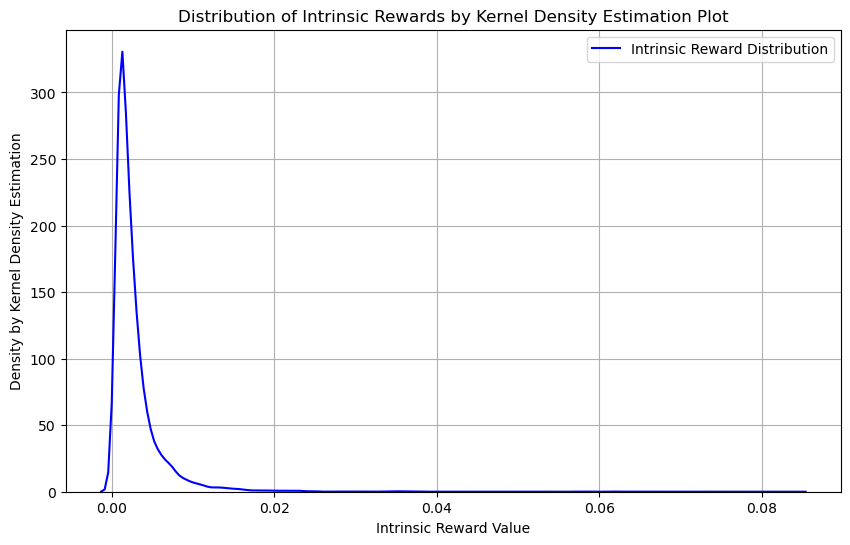

In [7]:
plt.figure(figsize=(10, 6))
sns.kdeplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution")  # 
plt.title("Distribution of Intrinsic Rewards by Kernel Density Estimation Plot")
plt.xlabel("Intrinsic Reward Value")
plt.ylabel("Density by Kernel Density Estimation")
plt.legend()
plt.grid(True)
plt.show()

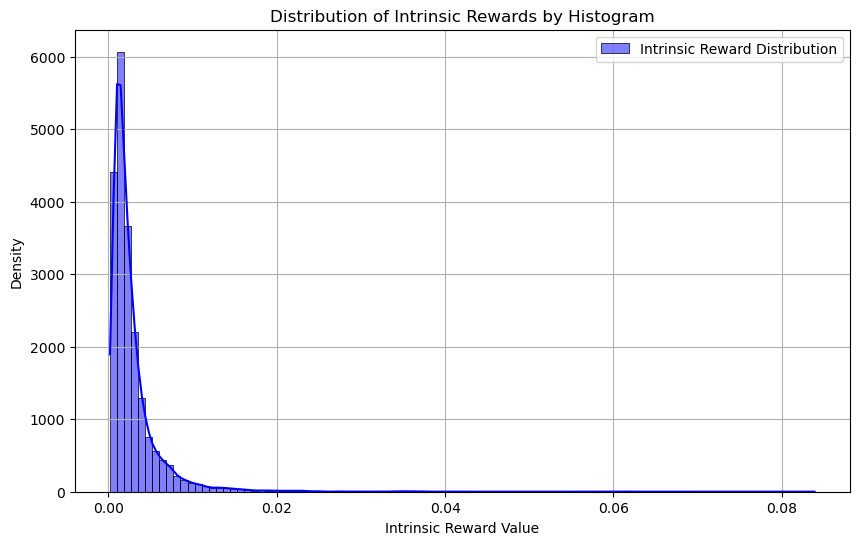

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution", bins=100, kde=True)
plt.title("Distribution of Intrinsic Rewards by Histogram")
plt.xlabel("Intrinsic Reward Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()